## Task: Predict Carbon Emissions Based on Satellite Observations

* You are provided with a time series satellite observations dataset extracted from Sentinel-5P satelite from 2019 to 2021.

* Your objective is to build a regression model that accurately predicts the amount of carbon emissions in the next years.

* Your target is the column: "emission".
    
---


In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error
import lightgbm as lgb
import kagglehub
import os
import seaborn as sns

#### Step 1: Load the dataset

In [2]:

# Download the dataset using KaggleHub
dataset_path = kagglehub.dataset_download("mohammad2012191/q3-data")
print("Path to dataset files:", dataset_path)

Path to dataset files: C:\Users\afiya\.cache\kagglehub\datasets\mohammad2012191\q3-data\versions\1


In [3]:
# Load the CSV file into a DataFrame
csv_path = os.path.join(dataset_path, "train.csv")
data = pd.read_csv(csv_path)

#### Step 2: Initial Data Inspection

In [4]:
# Display the first few rows and column names
data.head()

,ID_LAT_LON_YEAR_WEEK,latitude,longitude,year,week_no,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,...,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle,emission
0,ID_-0.510_29.290_2019_00,-0.51,29.29,2019,0,-0.000108,0.603019,-0.000065,0.255668,-98.593887,...,3664.436218,61085.809570,2615.120483,15.568533,0.272292,-12.628986,35.632416,-138.786423,30.752140,3.750994
1,ID_-0.510_29.290_2019_01,-0.51,29.29,2019,1,0.000021,0.728214,0.000014,0.130988,16.592861,...,3651.190311,66969.478735,3174.572424,8.690601,0.256830,30.359375,39.557633,-145.183930,27.251779,4.025176
2,ID_-0.510_29.290_2019_02,-0.51,29.29,2019,2,0.000514,0.748199,0.000385,0.110018,72.795837,...,4216.986492,60068.894448,3516.282669,21.103410,0.251101,15.377883,30.401823,-142.519545,26.193296,4.231381
3,ID_-0.510_29.290_2019_03,-0.51,29.29,2019,3,NaN,NaN,NaN,NaN,NaN,...,5228.507736,51064.547339,4180.973322,15.386899,0.262043,-11.293399,24.380357,-132.665828,28.829155,4.305286
4,ID_-0.510_29.290_2019_04,-0.51,29.29,2019,4,-0.000079,0.676296,-0.000048,0.121164,4.121269,...,3980.598120,63751.125781,3355.710107,8.114694,0.235847,38.532263,37.392979,-141.509805,22.204612,4.347317


In [5]:
# Drop unnecessary columns (e.g., ID_LAT_LON_YEAR_WEEK)
data.drop(columns=['ID_LAT_LON_YEAR_WEEK'], inplace=True)
data.tail()

,latitude,longitude,year,week_no,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,SulphurDioxide_sensor_zenith_angle,...,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle,emission
79018,-3.299,30.301,2021,48,0.000284,1.195643,0.000340,0.191313,72.820518,55.988022,...,5459.185355,60657.101913,4590.879504,20.245954,0.304797,-35.140368,40.113533,-129.935508,32.095214,29.404171
79019,-3.299,30.301,2021,49,0.000083,1.130868,0.000063,0.177222,-12.856753,19.435339,...,5606.449457,60168.191528,4659.130378,6.104610,0.314015,4.667058,47.528435,-134.252871,30.771469,29.186497
79020,-3.299,30.301,2021,50,NaN,NaN,NaN,NaN,NaN,NaN,...,6222.646776,56596.027209,5222.646823,14.817885,0.288058,-0.340922,35.328098,-134.731723,30.716166,29.131205
79021,-3.299,30.301,2021,51,-0.000034,0.879397,-0.000028,0.184209,-100.344827,32.599393,...,7896.456885,46533.348194,6946.858022,32.594768,0.274047,8.427699,48.295652,-139.447849,29.112868,28.125792
79022,-3.299,30.301,2021,52,-0.000091,0.871951,-0.000079,0.000000,76.825638,8.273742,...,7553.295016,47771.681887,6553.295018,19.464032,0.226276,-12.808528,47.923441,-136.299984,30.246387,27.239302


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79023 entries, 0 to 79022
Data columns (total 75 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   latitude                                                  79023 non-null  float64
 1   longitude                                                 79023 non-null  float64
 2   year                                                      79023 non-null  int64  
 3   week_no                                                   79023 non-null  int64  
 4   SulphurDioxide_SO2_column_number_density                  64414 non-null  float64
 5   SulphurDioxide_SO2_column_number_density_amf              64414 non-null  float64
 6   SulphurDioxide_SO2_slant_column_number_density            64414 non-null  float64
 7   SulphurDioxide_cloud_fraction                             64414 non-null  float64
 8   SulphurDioxide_s

In [7]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
latitude,79023.0,-1.891072,0.694522,-3.299000,-2.451000,-1.882000,-1.303000,-0.510000
longitude,79023.0,29.880155,0.810375,28.228000,29.262000,29.883000,30.471000,31.532000
year,79023.0,2020.000000,0.816502,2019.000000,2019.000000,2020.000000,2021.000000,2021.000000
week_no,79023.0,26.000000,15.297155,0.000000,13.000000,26.000000,39.000000,52.000000
SulphurDioxide_SO2_column_number_density,64414.0,0.000048,0.000272,-0.000996,-0.000096,0.000024,0.000153,0.004191
...,...,...,...,...,...,...,...,...
Cloud_sensor_azimuth_angle,78539.0,-10.784832,30.374462,-102.739731,-30.309170,-12.673914,9.402202,78.223037
Cloud_sensor_zenith_angle,78539.0,40.436976,6.428216,2.998873,35.829907,41.119630,44.446272,65.951248
Cloud_solar_azimuth_angle,78539.0,-86.800583,37.837269,-153.464211,-125.991158,-84.644352,-48.132701,-22.653170
Cloud_solar_zenith_angle,78539.0,27.925981,4.403835,10.818288,24.686763,28.333630,31.499883,42.060436


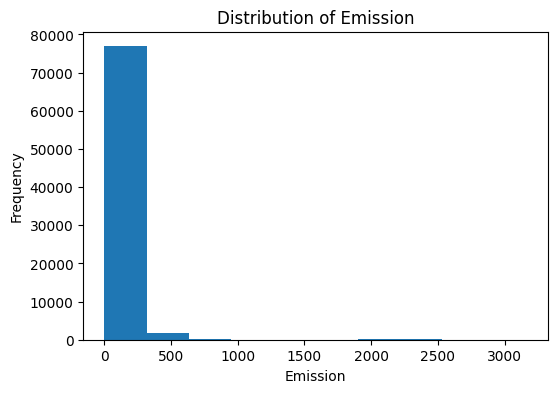

In [8]:
# Plot the distribution of the emission variable
plt.figure(figsize=(6, 4))
plt.hist(data["emission"])
plt.xlabel("Emission")
plt.ylabel("Frequency")
plt.title("Distribution of Emission")
plt.show()

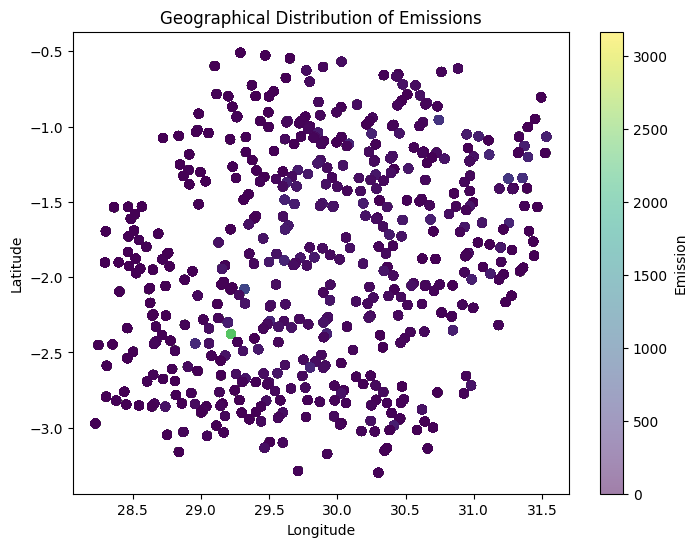

In [9]:
# Plot the "latitude" and "longitude" using a scatter plot then colorize the points using the "emission" column.

plt.figure(figsize=(8, 6))
plt.scatter(
    data["longitude"],
    data["latitude"],
    c=data["emission"],
    cmap="viridis",
    alpha=0.5
)
plt.colorbar(label="Emission")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Geographical Distribution of Emissions")
plt.show()


#### Step 3: Split Data into Training and Validation Sets
> Use samples from 2019 and 2020 as training data, and 2021 as validation data

In [10]:
# sort the data based on year and week_no
data = data.sort_values(by=['year', 'week_no'])

train_data = data[data["year"].isin([2019, 2020])].copy()
valid_data = data[data["year"] == 2021].copy()

#### Step 4: Handle Missing Values

In [11]:
# Calculate the threshold for dropping columns (50% of rows)
missing_threshold = 0.5 * len(train_data)

# Identify columns with more than 50% missing values
high_missing_cols = train_data.columns[train_data.isna().sum() > missing_threshold].tolist()
print("Columns with >50% missing values:", high_missing_cols)

Columns with >50% missing values: ['UvAerosolLayerHeight_aerosol_height', 'UvAerosolLayerHeight_aerosol_pressure', 'UvAerosolLayerHeight_aerosol_optical_depth', 'UvAerosolLayerHeight_sensor_zenith_angle', 'UvAerosolLayerHeight_sensor_azimuth_angle', 'UvAerosolLayerHeight_solar_azimuth_angle', 'UvAerosolLayerHeight_solar_zenith_angle']


In [12]:
# Drop these columns from both training and validation sets
train_data.drop(columns=high_missing_cols, inplace=True)
valid_data.drop(columns=high_missing_cols, inplace=True)

# Impute remaining missing values with the median (calculated from training data only)
imputer = SimpleImputer(strategy='median')
imputer.fit(train_data)  # Fit on training data only

# Transform both training and validation data
train_data = pd.DataFrame(imputer.transform(train_data), columns=train_data.columns)
valid_data = pd.DataFrame(imputer.transform(valid_data), columns=valid_data.columns)

In [13]:
print(train_data.shape)
print(valid_data.shape)
train_data.head()

(52682, 68)
(26341, 68)


,latitude,longitude,year,week_no,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,SulphurDioxide_sensor_zenith_angle,...,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle,emission
0,-0.510,29.290,2019.0,0.0,-0.000108,0.603019,-0.000065,0.255668,-98.593887,50.843559,...,3664.436218,61085.809570,2615.120483,15.568533,0.272292,-12.628986,35.632416,-138.786423,30.752140,3.750994
1,-0.528,29.472,2019.0,0.0,0.000019,0.709144,0.000014,0.134741,-98.501511,51.844101,...,4001.152273,63069.690906,3213.283931,18.926705,0.214483,-12.516482,35.564368,-138.523453,30.907505,3.857115
2,-0.547,29.653,2019.0,0.0,-0.000003,0.644523,0.000002,0.159232,-98.442759,52.516869,...,4540.656386,61790.449113,3757.115933,14.942300,0.218611,-12.424014,35.551288,-138.308677,31.027002,0.500023
3,-0.569,30.031,2019.0,0.0,-0.000084,0.707230,-0.000059,0.150600,73.134705,49.526180,...,4783.908016,55450.655574,3735.628591,20.669712,0.287372,4.514736,41.459575,-141.751064,29.854191,100.382980
4,-0.598,29.102,2019.0,0.0,-0.000019,0.841109,-0.000016,0.235381,76.165604,15.930818,...,3727.795313,60369.755676,2678.920405,14.724678,0.260578,-12.673878,35.704096,-138.924499,30.708915,0.076542


In [14]:
valid_data.head()

,latitude,longitude,year,week_no,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,SulphurDioxide_sensor_zenith_angle,...,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle,emission
0,-0.510,29.290,2021.0,0.0,0.000026,0.827394,0.00002,0.162844,-12.696201,37.504934,...,8158.284912,43203.886719,7158.284912,13.620904,0.348412,-12.744946,60.345203,-140.402161,31.679763,3.319557
1,-0.528,29.472,2021.0,0.0,0.000026,0.827394,0.00002,0.162844,-12.696201,37.504934,...,9468.693848,35862.816406,8468.693848,26.928258,0.165474,-12.680294,60.318911,-140.141655,31.836250,3.127358
2,-0.547,29.653,2021.0,0.0,0.000026,0.827394,0.00002,0.162844,-12.696201,37.504934,...,10102.477539,33245.333008,9102.477539,31.407574,0.230537,-12.620838,60.251894,-139.839546,31.948181,0.469961
3,-0.569,30.031,2021.0,0.0,0.000026,0.827394,0.00002,0.162844,-12.696201,37.504934,...,7819.550293,44690.457031,6819.550293,78.404991,0.389910,72.468605,55.983418,-151.650864,25.450575,90.212845
4,-0.598,29.102,2021.0,0.0,0.000026,0.827394,0.00002,0.162844,-12.696201,37.504934,...,6734.331747,52624.530596,5734.331747,30.443385,0.372902,-12.781406,60.337599,-140.554855,31.605461,0.071976


#### Step 5: Feature Engineering

In [15]:
# Combine latitude and longitude into a single 'location' feature
train_data['location'] = train_data['latitude'].astype(str) + ', ' + train_data['longitude'].astype(str)
valid_data['location'] = valid_data['latitude'].astype(str) + ', ' + valid_data['longitude'].astype(str)

# Calculate the average emission per location using the training data
location_avg_emission = train_data.groupby('location')['emission'].mean().reset_index()
location_avg_emission.rename(columns={'emission': 'avg_emission_per_location'}, inplace=True)

# Merge this feature into both training and validation sets
train_data = train_data.merge(location_avg_emission, on='location', how='left')
valid_data = valid_data.merge(location_avg_emission, on='location', how='left')

#### Step 6: Encode Categorical Features (if any)

In [16]:
# Identify categorical columns (if any remain)
categorical_cols = train_data.select_dtypes(include=["object"]).columns.tolist()
print("Categorical columns before encoding:", categorical_cols)

# Apply Label Encoding to categorical columns (fit on training data only)
le = LabelEncoder()
for col in categorical_cols:
    train_data[col] = le.fit_transform(train_data[col])
    # Use the same encoder for validation data
    valid_data[col] = le.transform(valid_data[col]) 

Categorical columns before encoding: ['location']


#### Step 7: Prepare Data for Modeling

In [17]:
# Define features and target
features_to_drop = ["emission"]
X_train = train_data.drop(columns=features_to_drop)
y_train = train_data["emission"]

X_valid = valid_data.drop(columns=features_to_drop)
y_valid = valid_data["emission"]

#### Step 8: Train a LightGBM Model

In [18]:

# Initialize the LightGBM regressor
model = lgb.LGBMRegressor(force_col_wise='True', random_state=42)

# Train the model on the training data
model.fit(X_train, y_train)

[LightGBM] [Info] Total Bins 17141
[LightGBM] [Info] Number of data points in the train set: 52682, number of used features: 69
[LightGBM] [Info] Start training from score 81.623719


LGBMRegressor(force_col_wise='True', random_state=42)

#### Step 9: Sort Feature Importances

In [19]:
# Get feature importances and corresponding feature names
feature_importances = model.feature_importances_
features = X_train.columns

# Sort features by importance (highest to lowest)
sorted_indices = np.argsort(feature_importances)[::-1]
sorted_features = features[sorted_indices]
sorted_importances = feature_importances[sorted_indices]

#### Step 10: Incremental Feature Selection

In [20]:
results = []

# Start with the top 3 features and incrementally add one feature at a time
for num_features in range(3, len(sorted_features) + 1):
    # Select the top 'num_features' features
    selected_features = sorted_features[:num_features]
    
    # Prepare training and validation data with the selected features
    X_train_selected = X_train[selected_features]
    X_valid_selected = X_valid[selected_features]
    
    # Train a new LightGBM model with the selected features
    model_selected = lgb.LGBMRegressor(force_col_wise='True', random_state=42)
    model_selected.fit(X_train_selected, y_train)
    
    # Make predictions on the validation set
    predictions_selected = model_selected.predict(X_valid_selected)
    
    # Calculate MAE for the current feature set
    mae = mean_absolute_error(y_valid, predictions_selected)
    
    # Store results
    results.append({
        'Num Features': num_features,
        'Selected Features': selected_features.tolist(),
        'MAE': mae
    })
    
    # Print results for the current feature set
    print(f"\nNumber of Features: {num_features}")
    print(f"Selected Features: {selected_features.tolist()}")
    print(f"MAE: {mae:.4f}")

[LightGBM] [Info] Total Bins 563
[LightGBM] [Info] Number of data points in the train set: 52682, number of used features: 3
[LightGBM] [Info] Start training from score 81.623719

Number of Features: 3
Selected Features: ['avg_emission_per_location', 'week_no', 'latitude']
MAE: 7.9079
[LightGBM] [Info] Total Bins 818
[LightGBM] [Info] Number of data points in the train set: 52682, number of used features: 4
[LightGBM] [Info] Start training from score 81.623719

Number of Features: 4
Selected Features: ['avg_emission_per_location', 'week_no', 'latitude', 'longitude']
MAE: 7.5429
[LightGBM] [Info] Total Bins 1073
[LightGBM] [Info] Number of data points in the train set: 52682, number of used features: 5
[LightGBM] [Info] Start training from score 81.623719

Number of Features: 5
Selected Features: ['avg_emission_per_location', 'week_no', 'latitude', 'longitude', 'Ozone_O3_column_number_density']
MAE: 8.6621
[LightGBM] [Info] Total Bins 1076
[LightGBM] [Info] Number of data points in the 

In [21]:
df_results = pd.DataFrame(results)

#### Step 11: Find the Best Performance

In [22]:
# Identify the feature set with the lowest MAE (Lowest MAE, Best Score)
best_result = df_results.loc[df_results['MAE'].idxmin()]

# Print the best performance
print(f"\nBest Performance for Regression with {best_result['Num Features']} Features:")
print(f"MAE: {best_result['MAE']:.4f}")
print(f"Selected Features: {best_result['Selected Features']}")


Best Performance for Regression with 4 Features:
MAE: 7.5429
Selected Features: ['avg_emission_per_location', 'week_no', 'latitude', 'longitude']


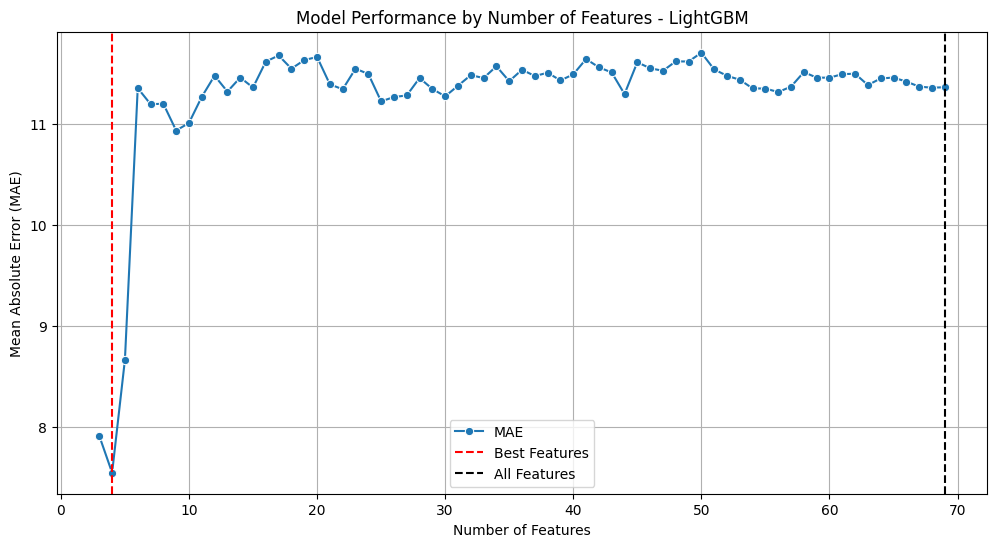

In [23]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_results, x='Num Features', y='MAE', marker='o', label='MAE')
plt.axvline(x=best_result['Num Features'], color='r', linestyle='--', label='Best Features')

all_features = df_results['Num Features'].max()
plt.axvline(x=all_features, color='black', linestyle='--', label='All Features')

plt.title('Model Performance by Number of Features - LightGBM')
plt.xlabel('Number of Features')
plt.ylabel('Mean Absolute Error (MAE)')
plt.legend()
plt.grid(True)
plt.show()

### Baseline Model

In [25]:
# Calculate the median emission from the training data
baseline_value = train_data['emission'].median()

# Create baseline predictions for the validation set (constant prediction)
baseline_predictions = np.full(shape=len(valid_data), fill_value=baseline_value)

# Calculate MAE for the baseline model
baseline_mae = mean_absolute_error(y_valid, baseline_predictions)
print(f"Baseline MAE (using median prediction): {baseline_mae:.4f}")

Baseline MAE (using median prediction): 67.6319


#### Plot the features importance of your model.

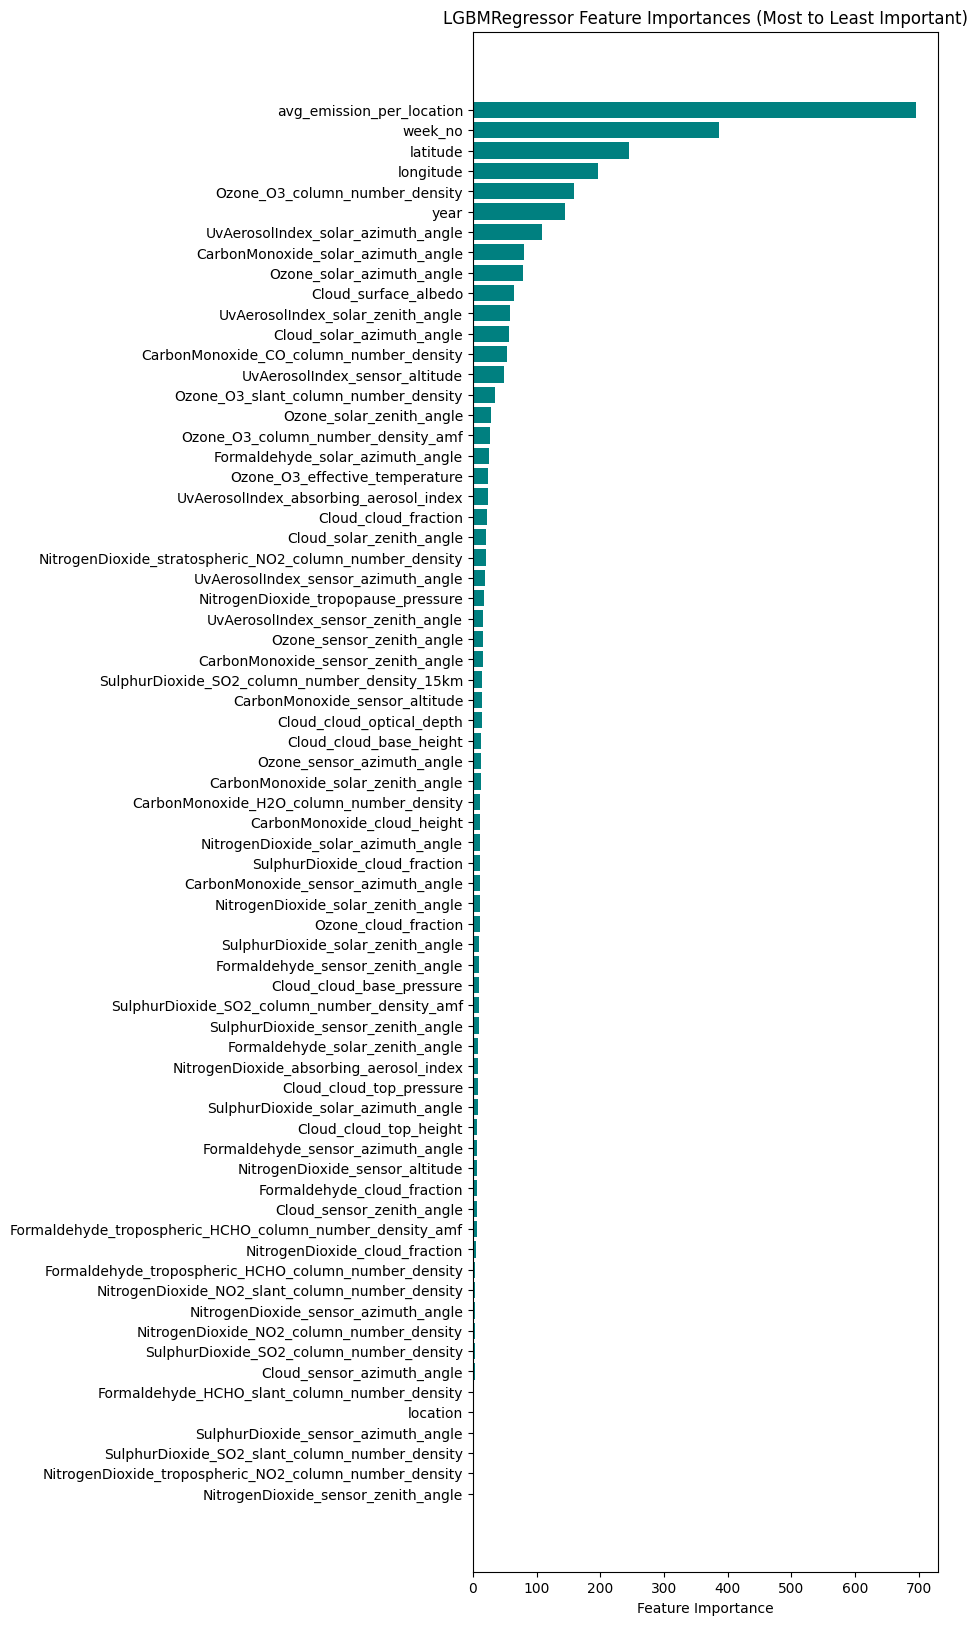

In [26]:
# Get feature importances and corresponding feature names
feature_importances = model.feature_importances_
features = X_train.columns

# Sort features and their importances in descending order
sorted_indices = np.argsort(feature_importances)[::-1]  # Indices for sorting
sorted_features = features[sorted_indices]  # Features sorted by importance
sorted_importances = feature_importances[sorted_indices] 

# Plot feature importances (most important at the top)
plt.figure(figsize=(6, 20))
plt.barh(sorted_features[::-1], sorted_importances[::-1], color='teal')  # Reverse for correct order
plt.xlabel("Feature Importance")
plt.title("LGBMRegressor Feature Importances (Most to Least Important)")
plt.show()

#### Plot the validation predictions using a histogram.

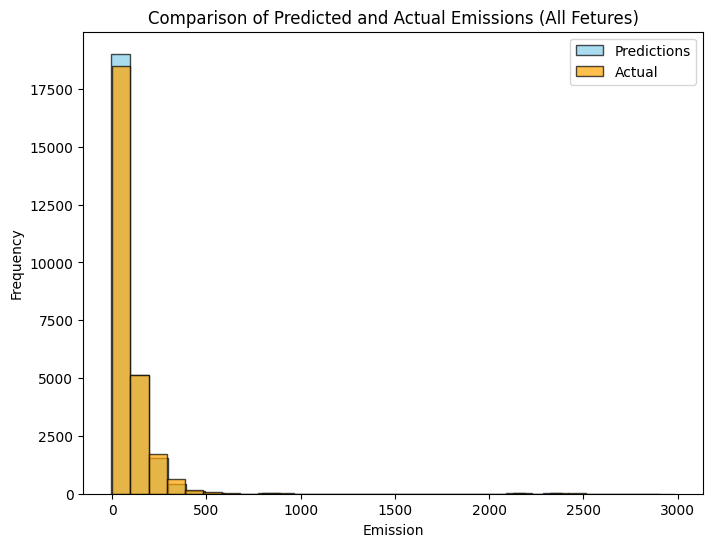

In [27]:
# Make predictions on the validation set
predictions = model.predict(X_valid)

plt.figure(figsize=(8, 6))
plt.hist(predictions, bins=30, color="skyblue", edgecolor="black", alpha=0.7, label="Predictions")
plt.hist(y_valid, bins=30, color="orange", edgecolor="black", alpha=0.7, label="Actual")
plt.xlabel("Emission")
plt.ylabel("Frequency")
plt.title("Comparison of Predicted and Actual Emissions (All Fetures)")
plt.legend()
plt.show()

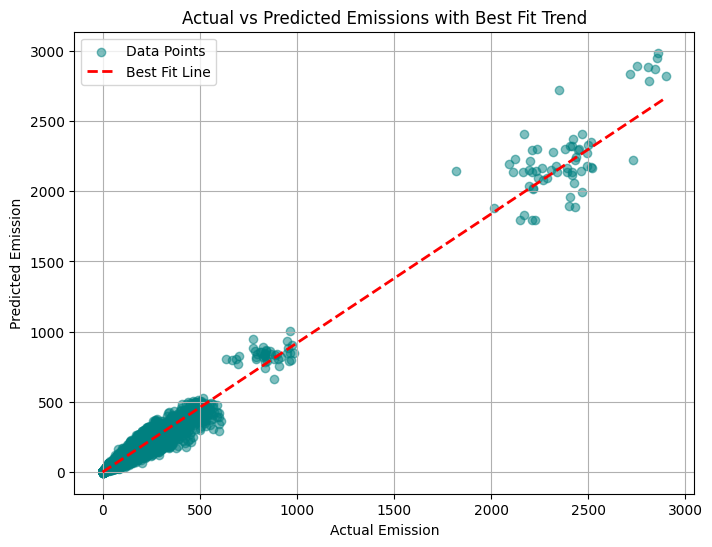

In [33]:
# Compute the best fit line using numpy's polyfit
slope, intercept = np.polyfit(y_valid, predictions, 1)
x_vals = np.linspace(y_valid.min(), y_valid.max(), 100)
y_fit = slope * x_vals + intercept

# Plot the scatter plot and the best fit line
plt.figure(figsize=(8, 6))
plt.scatter(y_valid, predictions, color='teal', alpha=0.5, label='Data Points')
plt.plot(x_vals, y_fit, color='red', linestyle='--', linewidth=2, label='Best Fit Line')
plt.xlabel("Actual Emission")
plt.ylabel("Predicted Emission")
plt.title("Actual vs Predicted Emissions with Best Fit Trend")
plt.legend()
plt.grid(True)
plt.show()
